# Self-seeding example 

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys
sys.path.append('/Users/riverr/Documents/pyfel1d/main/')
from particles import ParticleLoader
from fel import OneDFELSolver, LinearTheory
import time

This notebook shows an example of a two-stage self-seeding simulation

# Simulation set up 

In [35]:
solver = OneDFELSolver(Lzhat=10, ## undulator length
                       Nzhat=500, ## number of steps in undulator
                       Lzeta=200,
                       Nzeta=1000,
                       time_independent=False)

In [36]:
## define beam profile 

beam_zeta0 = solver.zeta_arr.mean()
beam_rms = 60
beam_supergauss_n = 3

solver.chi = np.exp(-(solver.zeta_arr - beam_zeta0)**(2*beam_supergauss_n)/(2*beam_rms**(2*beam_supergauss_n)))

In [37]:
solver.generate_beam(bdes=4e-4, 
                     slice_espread_function=lambda Np: np.random.normal(0, 0.5, Np))

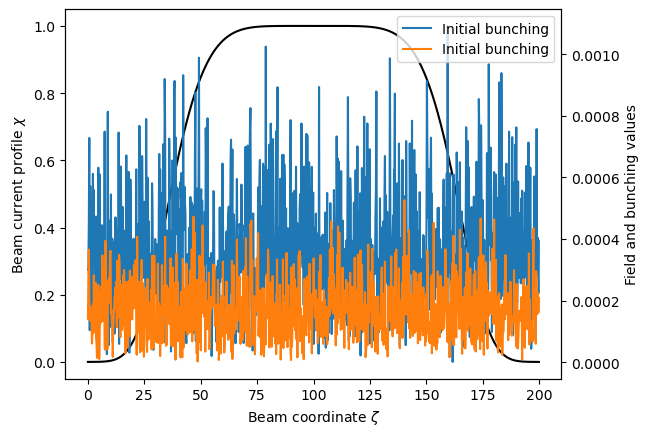

In [38]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(solver.zeta_arr, solver.chi, 'k')

ax2.plot(solver.zeta_arr, np.abs(solver.calculate_moments(1,0)), label='Initial bunching')
ax2.plot(solver.zeta_arr, np.abs(solver.calculate_moments(1,1)), label='Initial bunching')
ax.set_xlabel(r'Beam coordinate $\zeta$')
ax.set_ylabel(r'Beam current profile $\chi$')
ax2.set_ylabel(r'Field and bunching values')
ax2.legend()

# Run simulation and look at results

In [39]:
%%time
solver.run_simulation(steps_between_store = 10, ## store the field every 10 steps 
                      verbose=True) ## print status in 10% intervals 

Found no input harmonics array, assuming only first harmonic present
Found no input taper array, assuming it is zero everywhere
Input seed field $a_0$ is unspecified, setting it to zero
Beginning simulation including harmonics: [1]
0% done
10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
Done
CPU times: user 1min 9s, sys: 2.05 s, total: 1min 11s
Wall time: 9.11 s


Text(0, 0.5, 'Undulator coordinate $\\hat{z}$')

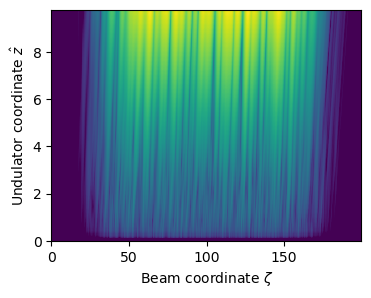

In [40]:
plt.figure(figsize=(4,3))
plt.imshow(1e-12+np.abs(solver.a_store)**2, aspect='auto', origin='lower', norm=LogNorm(vmin=1e-10), extent=[0, solver.zeta_arr.max(), 0, solver.zhat_store.max()])
plt.xlabel(r'Beam coordinate $\zeta$')
plt.ylabel(r'Undulator coordinate $\hat{z}$')


Text(0, 0.5, 'Average power $|a|^2$')

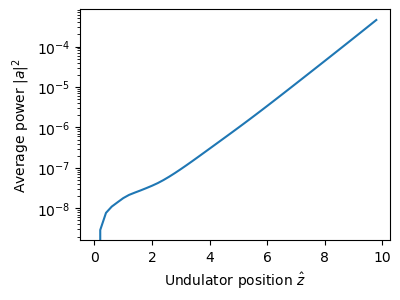

In [41]:
plt.figure(figsize=(4,3))
plt.plot(solver.zhat_store, (np.abs(solver.a_store)**2).mean(axis=-1))
plt.yscale('log')

plt.xlabel(r'Undulator position $\hat{z}$')
plt.ylabel(r'Average power $|a|^2$')

/var/folders/rx/p106nzns0lqg6mgzkh1lq9p93pr40t/T/ipykernel_50966/3684255755.py:9: RuntimeWarning: invalid value encountered in divide
  power_norm = power / power.max()


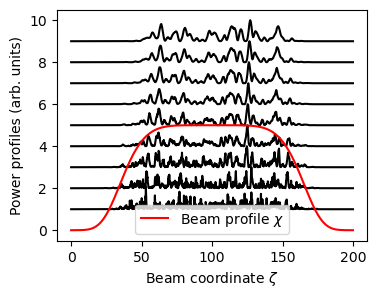

In [42]:
plt.figure(figsize=(4,3))
nplot = 10

zinds = np.linspace(0, len(solver.zhat_store)-1, nplot).astype(int)

for i in range(nplot):
    zind = zinds[i]
    power = np.abs(solver.a_store[zind])**2
    power_norm = power / power.max()
    plt.plot(solver.zeta_arr, i + power_norm, 'k')

plt.plot(solver.zeta_arr, nplot/2*solver.chi, 'r', label=r'Beam profile $\chi$')
plt.xlabel(r'Beam coordinate $\zeta$')
plt.ylabel('Power profiles (arb. units)')
plt.legend()


# Filtering the first stage

In [43]:
a_first_stage = solver.a_final 
zeta = solver.zeta_arr 

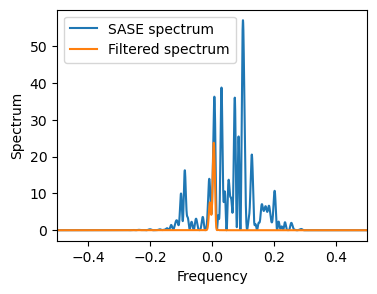

In [46]:
plt.figure(figsize=(4,3))

padding = 10000
a_padded = np.pad(a_first_stage, padding)
a_fft = np.fft.fftshift(np.fft.fft(a_padded))
padded_freqs = np.fft.fftshift(np.fft.fftfreq(a_padded.shape[-1], solver.dzeta))

plt.plot(padded_freqs, np.abs(a_fft)**2, label='SASE spectrum')
plt.xlim(-0.5, 0.5)

mono_bw_rms = 0.01
mono_center = 0.0
mono_filter = np.exp(-(padded_freqs - mono_center)**2/(2*mono_bw_rms**2))
a_fft_filtered = a_fft*mono_filter

plt.plot(padded_freqs, np.abs(a_fft_filtered)**2, label='Filtered spectrum')
plt.xlabel('Frequency')
plt.ylabel('Spectrum')
plt.legend()

a_padded_filtered = np.fft.ifft(np.fft.ifftshift(a_fft_filtered))
a_filtered = a_padded_filtered[padding:-padding]


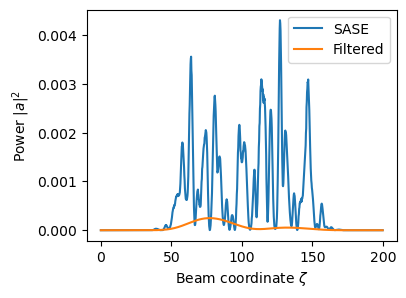

In [47]:
plt.figure(figsize=(4,3))
plt.plot(solver.zeta_arr, np.abs(a_first_stage)**2, label='SASE')
plt.plot(solver.zeta_arr, np.abs(a_filtered)**2, label='Filtered')
plt.xlabel(r'Beam coordinate $\zeta$')
plt.ylabel(r'Power $|a|^2$')
plt.legend()

Self-seeding often involves using a chicane to delay the e-beam and wash out the micro-bunching from the first stage. For this example we'll just apply R56 to wash out the microbunching.

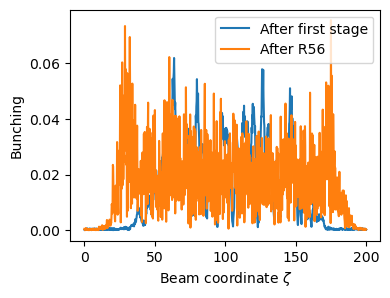

In [48]:
solver.a0 = a_filtered

theta_first_stage = solver.theta_final
eta_first_stage = solver.eta_final

plt.figure(figsize=(4,3))
plt.plot(solver.zeta_arr, np.abs(np.mean(np.exp(1j*theta_first_stage), axis=1)), label='After first stage')

R56 = 1e3
solver.theta0 = theta_first_stage + R56*eta_first_stage
solver.eta0 = eta_first_stage

plt.plot(solver.zeta_arr, np.abs(np.mean(np.exp(1j*solver.theta0), axis=1)), label='After R56')

plt.xlabel(r'Beam coordinate $\zeta$')
plt.ylabel(r'Bunching')
plt.legend()

In [49]:
solver.change_Lzhat_keep_step(10) ## for the second stage, we'll simulate a longer undulator

In [50]:
%%time
solver.run_simulation(steps_between_store = 10, ## store the field every 10 steps 
                      verbose=True) ## print status in 10% intervals 

Found no input taper array, assuming it is zero everywhere
Beginning simulation including harmonics: [1]
0% done
10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
Done
CPU times: user 1min 17s, sys: 2.07 s, total: 1min 20s
Wall time: 9.47 s


Text(0, 0.5, 'Undulator coordinate $\\hat{z}$')

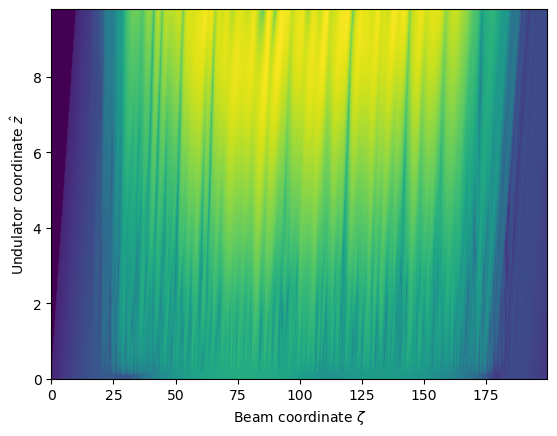

In [51]:
plt.imshow(1e-12+np.abs(solver.a_store)**2, aspect='auto', origin='lower', norm=LogNorm(vmin=1e-10), extent=[0, solver.zeta_arr.max(), 0, solver.zhat_store.max()])
plt.xlabel(r'Beam coordinate $\zeta$')
plt.ylabel(r'Undulator coordinate $\hat{z}$')


Text(0, 0.5, 'Average power $|a|^2$')

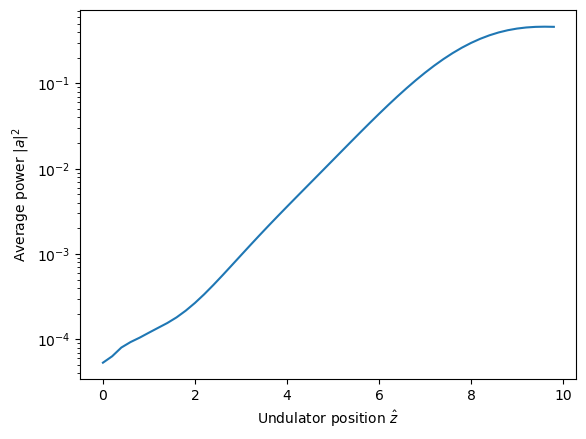

In [52]:
plt.plot(solver.zhat_store, (np.abs(solver.a_store)**2).mean(axis=-1))
plt.yscale('log')

plt.xlabel(r'Undulator position $\hat{z}$')
plt.ylabel(r'Average power $|a|^2$')

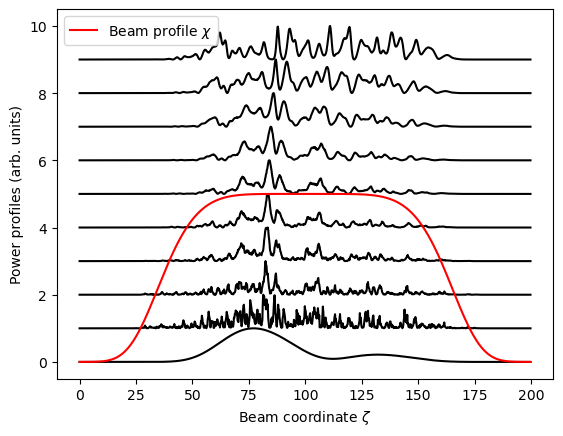

In [53]:
nplot = 10

zinds = np.linspace(0, len(solver.zhat_store)-1, nplot).astype(int)

for i in range(nplot):
    zind = zinds[i]
    power = np.abs(solver.a_store[zind])**2
    power_norm = power / power.max()
    plt.plot(solver.zeta_arr, i + power_norm, 'k')

plt.plot(solver.zeta_arr, nplot/2*solver.chi, 'r', label=r'Beam profile $\chi$')
plt.xlabel(r'Beam coordinate $\zeta$')
plt.ylabel('Power profiles (arb. units)')
plt.legend()


In [54]:
a_final = solver.a_final 

(-0.5, 0.5)

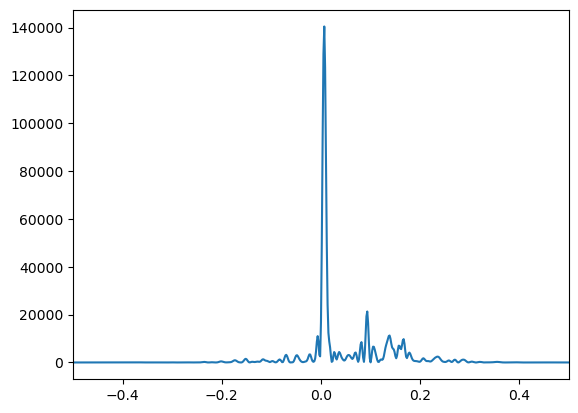

In [55]:
padding = 1000
a_padded = np.pad(a_final, padding)
a_fft = np.fft.fftshift(np.fft.fft(a_padded))
padded_freqs = np.fft.fftshift(np.fft.fftfreq(a_padded.shape[-1], solver.dzeta))

plt.plot(padded_freqs, np.abs(a_fft)**2)
plt.xlim(-0.5, 0.5)


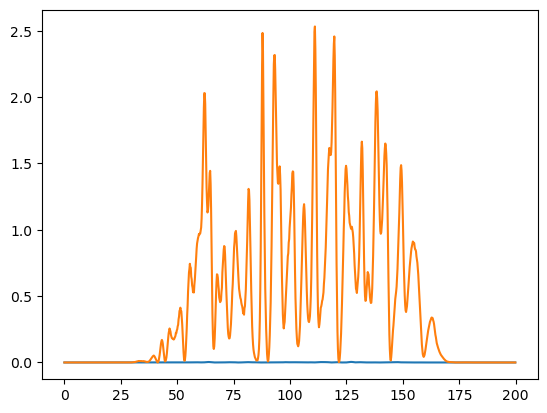

In [56]:
plt.plot(solver.zeta_arr, np.abs(a_first_stage)**2)
plt.plot(solver.zeta_arr, np.abs(solver.a_store[-1])**2)
